<a href="https://colab.research.google.com/github/SLCFLAB/Fintech2025/blob/main/DL_day14/14_2_Wasserstein_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Wasserstein Generative Adversarial Networks

Reference: https://github.com/eriklindernoren/PyTorch-GAN/tree/master



In [1]:
import argparse
import os
import numpy as np
import math
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch

import matplotlib.pyplot as plt

os.makedirs("images", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=20, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0005, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--n_critic", type=int, default=5, help="number of training steps for discriminator per iter")
parser.add_argument("--clip_value", type=float, default=0.01, help="lower and upper clip value for disc. weights")
parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen image samples")
opt = parser.parse_args(args=[])
print(opt)


Namespace(n_epochs=20, batch_size=64, lr=0.0005, b1=0.5, b2=0.999, n_cpu=8, latent_dim=100, img_size=28, channels=1, n_critic=5, clip_value=0.01, sample_interval=400)


In [2]:
img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False
cuda

True

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [4]:
k = 2
p = 6

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

In [5]:
# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.95MB/s]


In [6]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

<ipython-input-7-be8b5df99d15>:19: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[Epoch 0/20] [Batch 0/938] [D loss: 0.035729] [G loss: -0.017065]


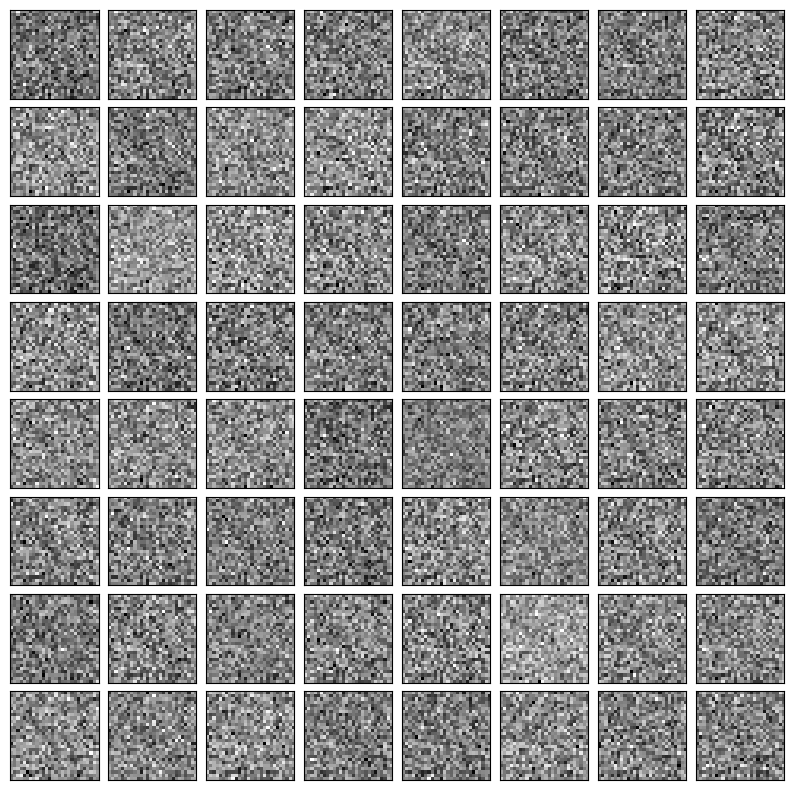

[Epoch 0/20] [Batch 600/938] [D loss: -3.245850] [G loss: 0.325334]


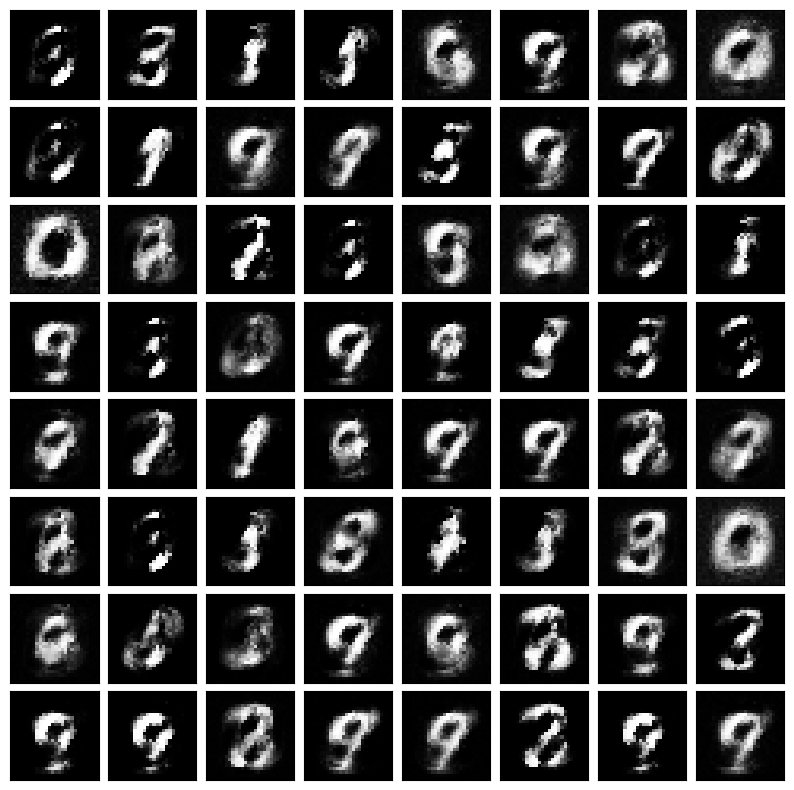

[Epoch 1/20] [Batch 0/938] [D loss: -2.769911] [G loss: 0.014884]


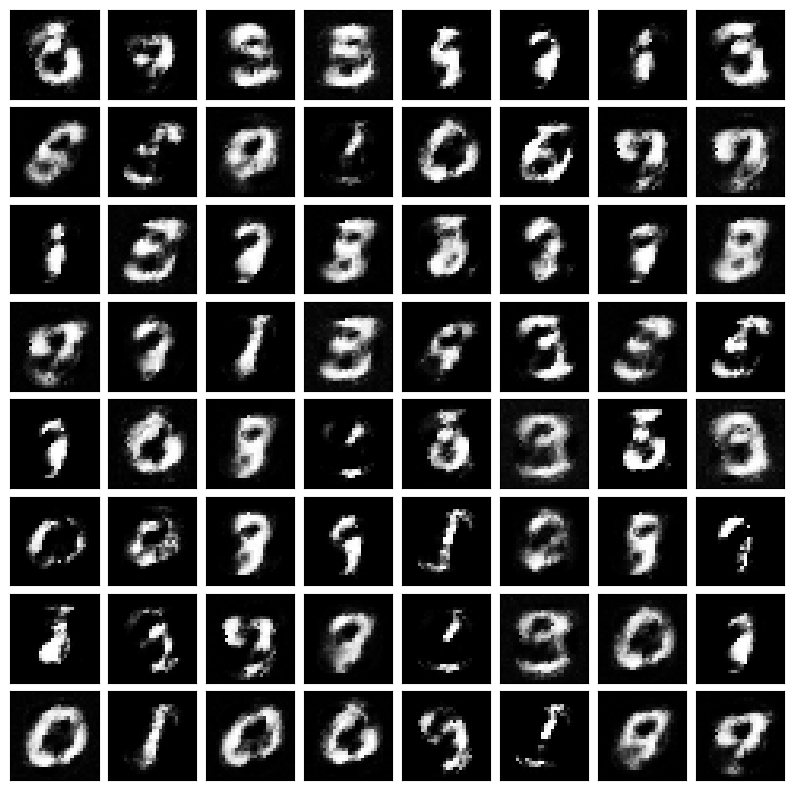

[Epoch 1/20] [Batch 600/938] [D loss: -3.202128] [G loss: 0.878802]


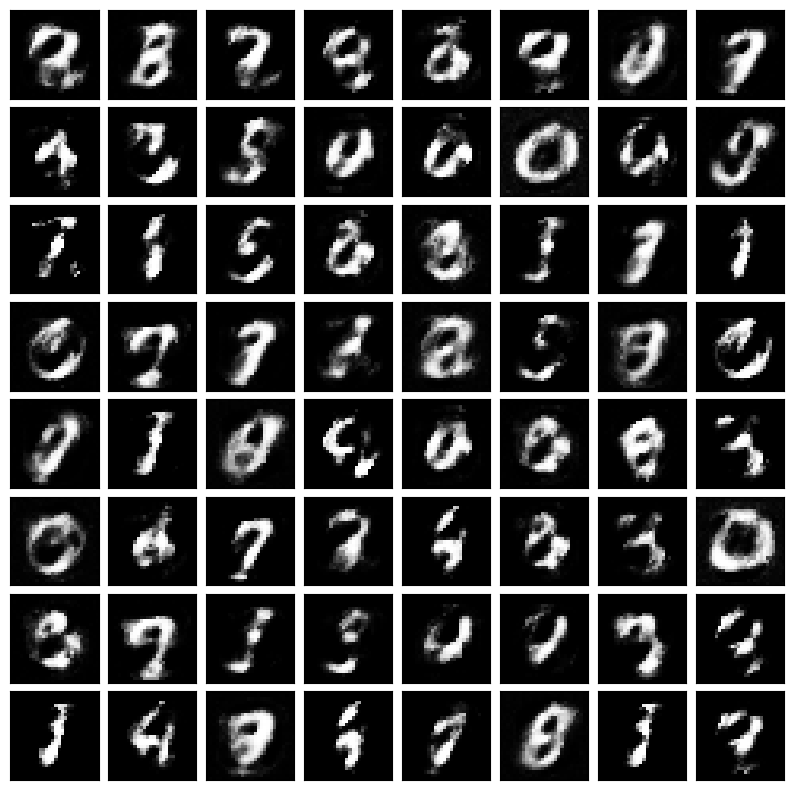

[Epoch 2/20] [Batch 0/938] [D loss: -2.821193] [G loss: 0.009834]


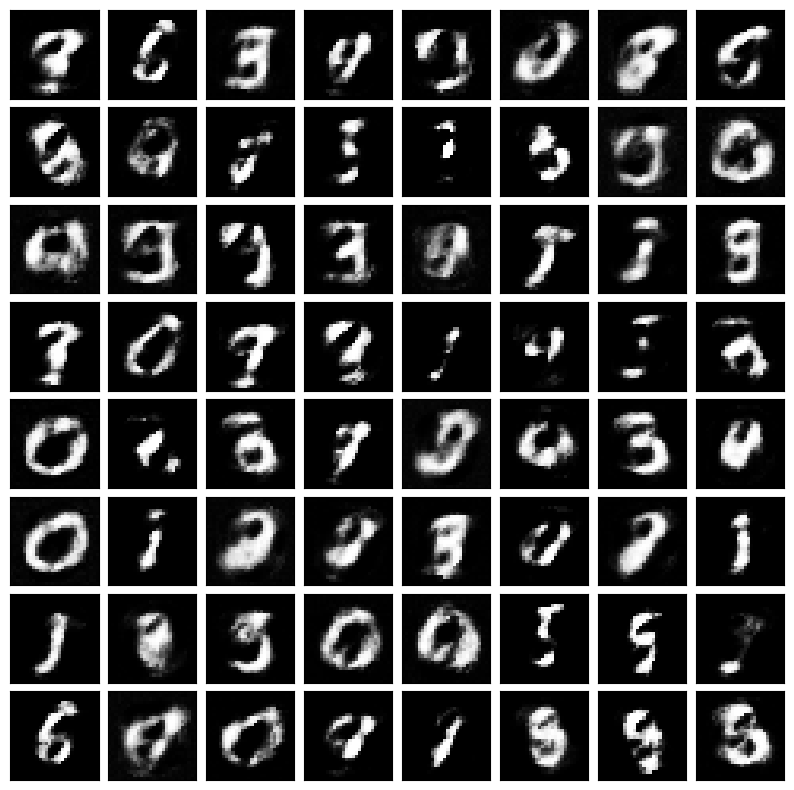

[Epoch 2/20] [Batch 600/938] [D loss: -2.687006] [G loss: 1.039625]


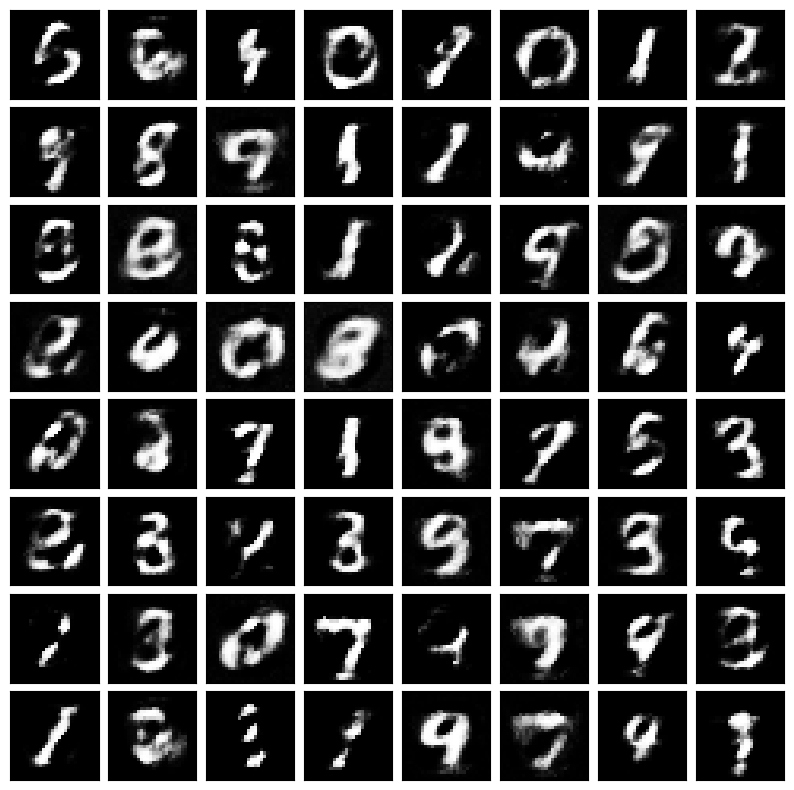

[Epoch 3/20] [Batch 0/938] [D loss: -2.068148] [G loss: -0.104241]


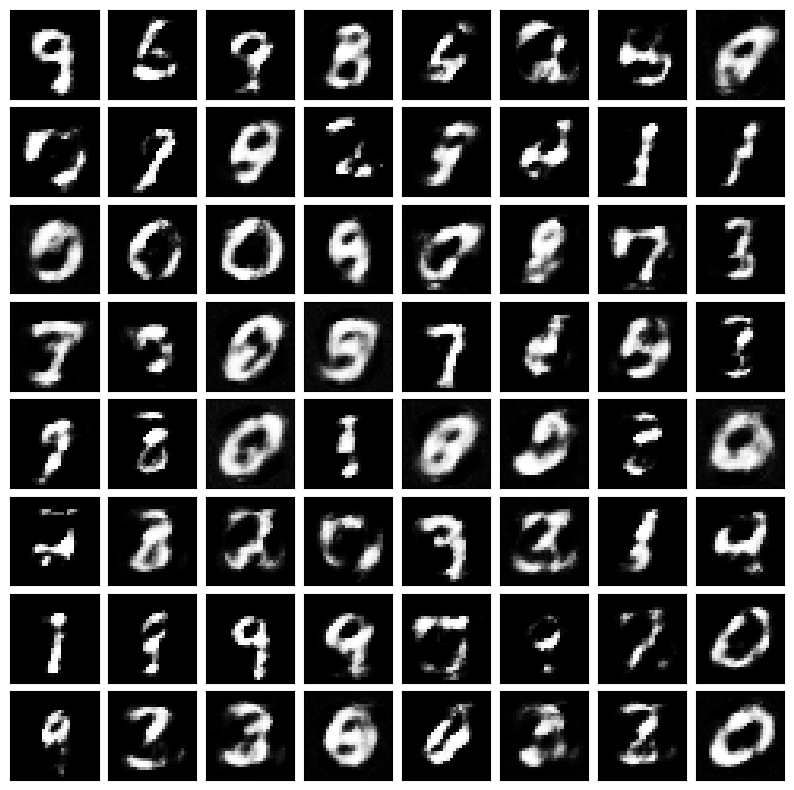

[Epoch 3/20] [Batch 600/938] [D loss: -2.151784] [G loss: -0.392421]


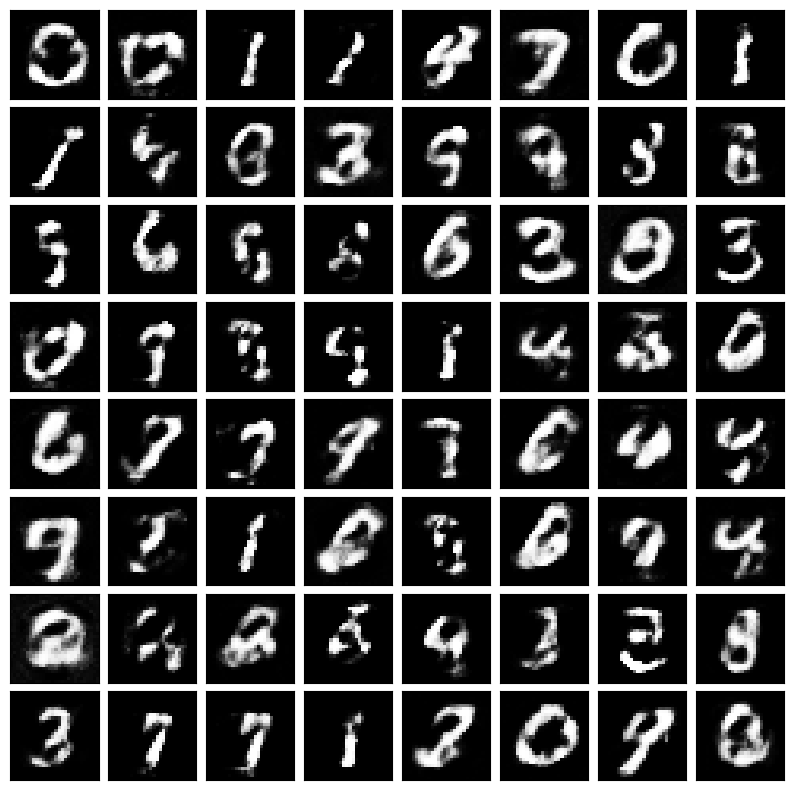

[Epoch 4/20] [Batch 0/938] [D loss: -1.859574] [G loss: 0.238422]


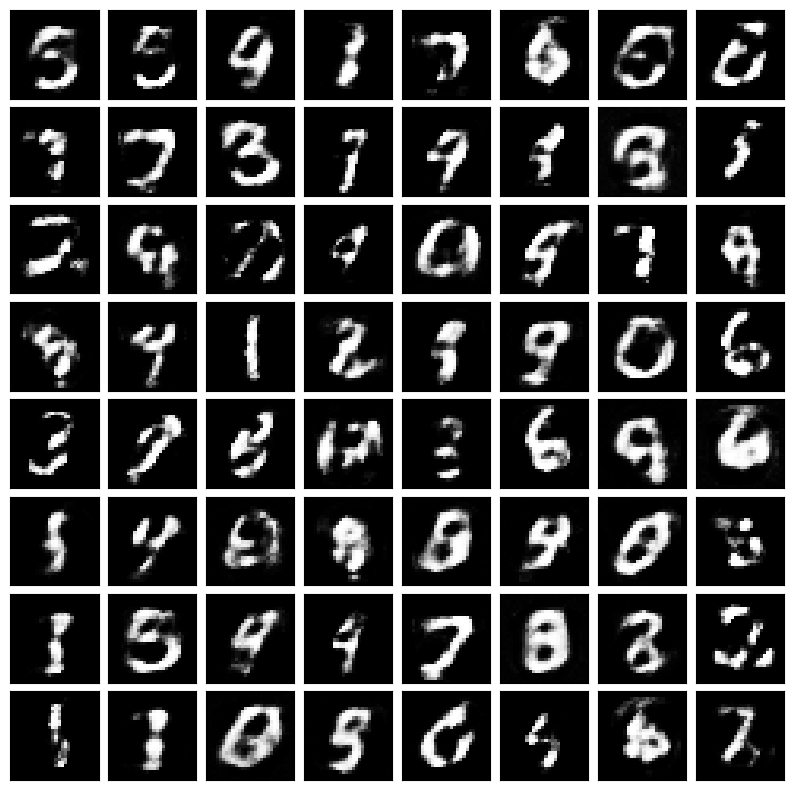

[Epoch 4/20] [Batch 600/938] [D loss: -1.327691] [G loss: -0.261576]


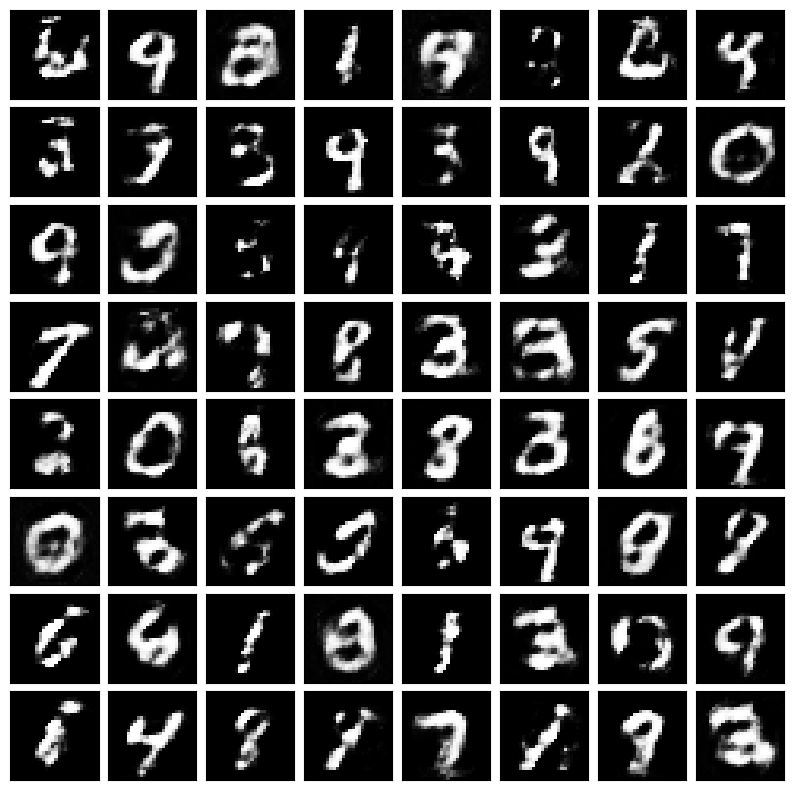

[Epoch 5/20] [Batch 0/938] [D loss: -1.527912] [G loss: 0.681580]


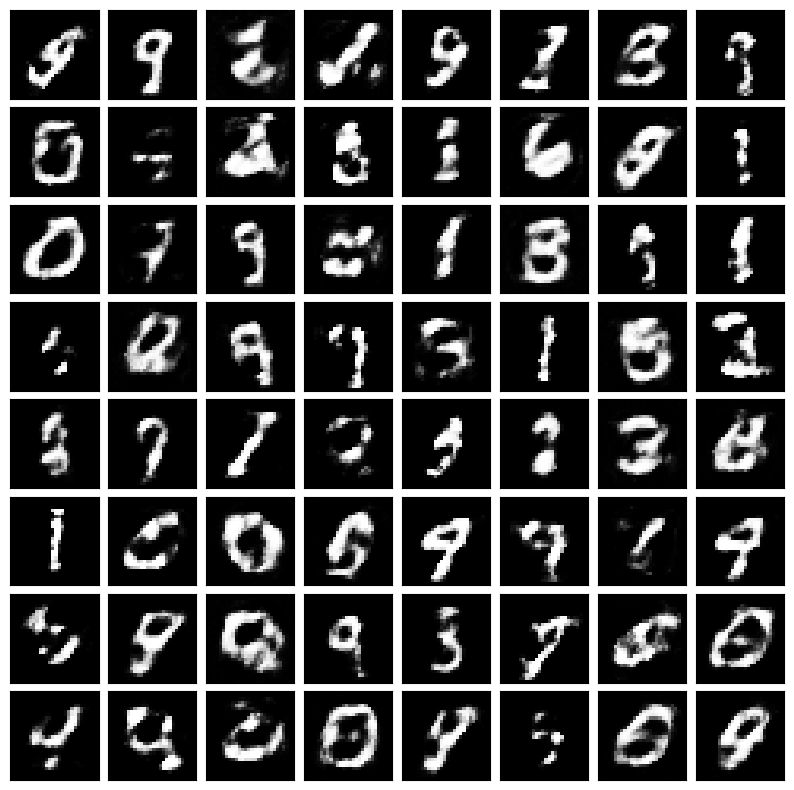

[Epoch 5/20] [Batch 600/938] [D loss: -1.589843] [G loss: 0.597033]


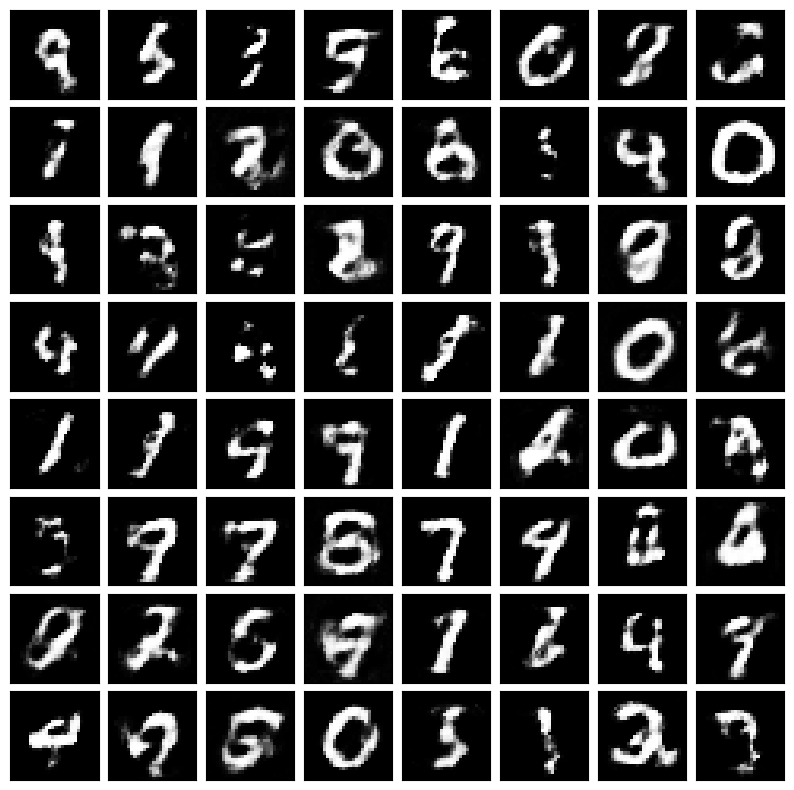

[Epoch 6/20] [Batch 0/938] [D loss: -1.250987] [G loss: -0.069870]


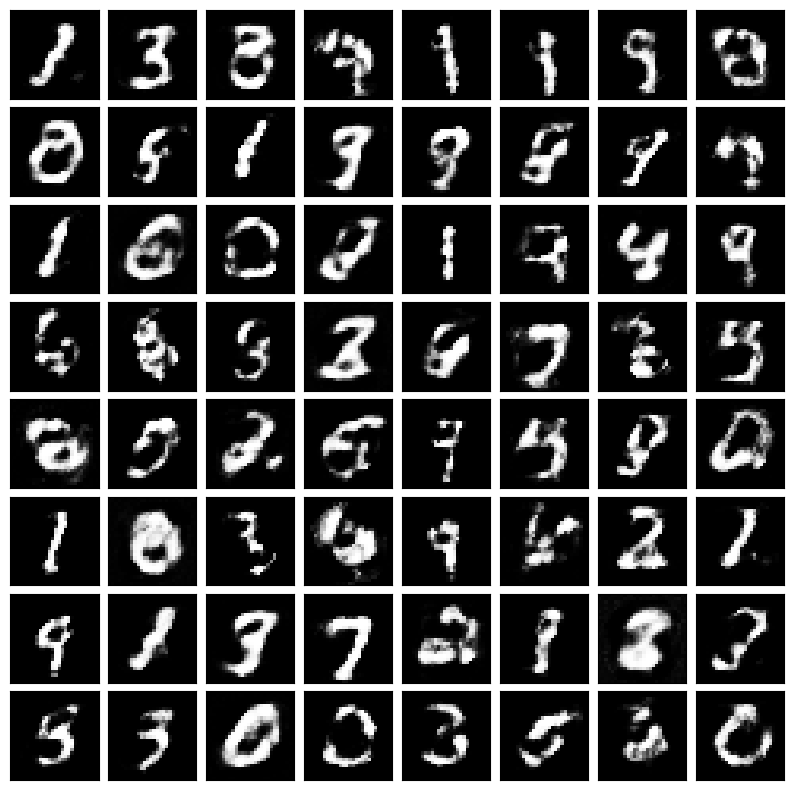

[Epoch 6/20] [Batch 600/938] [D loss: -1.405012] [G loss: -0.685093]


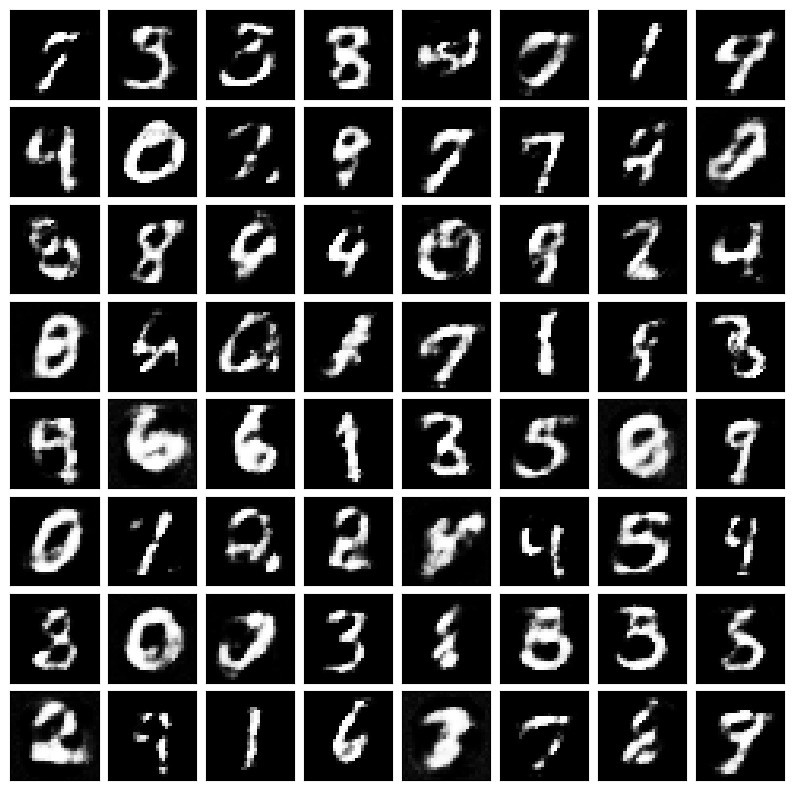

[Epoch 7/20] [Batch 0/938] [D loss: -1.394691] [G loss: 0.537582]


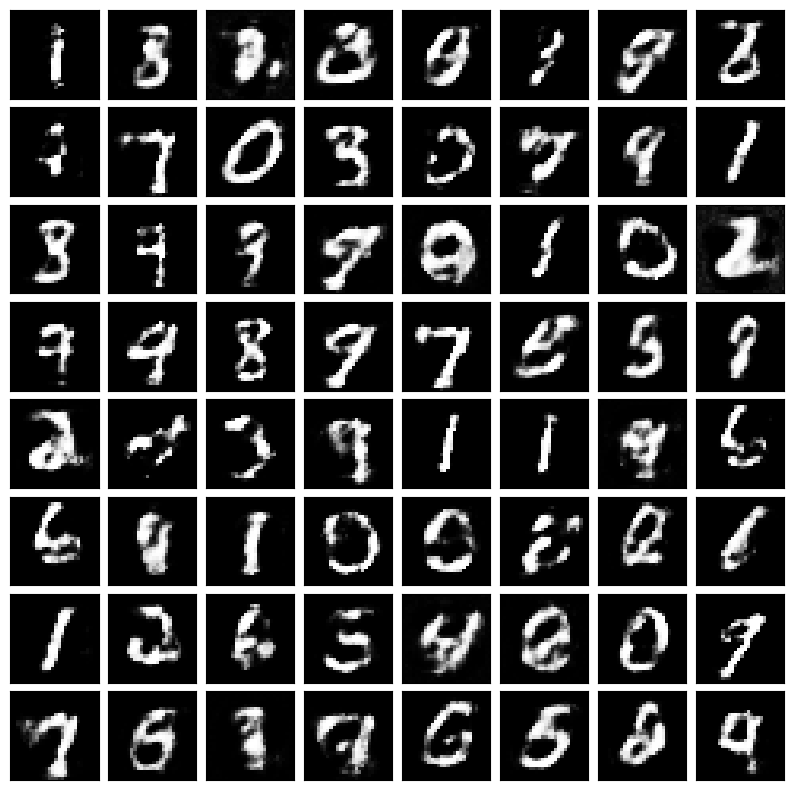

[Epoch 7/20] [Batch 600/938] [D loss: -1.603080] [G loss: -0.465261]


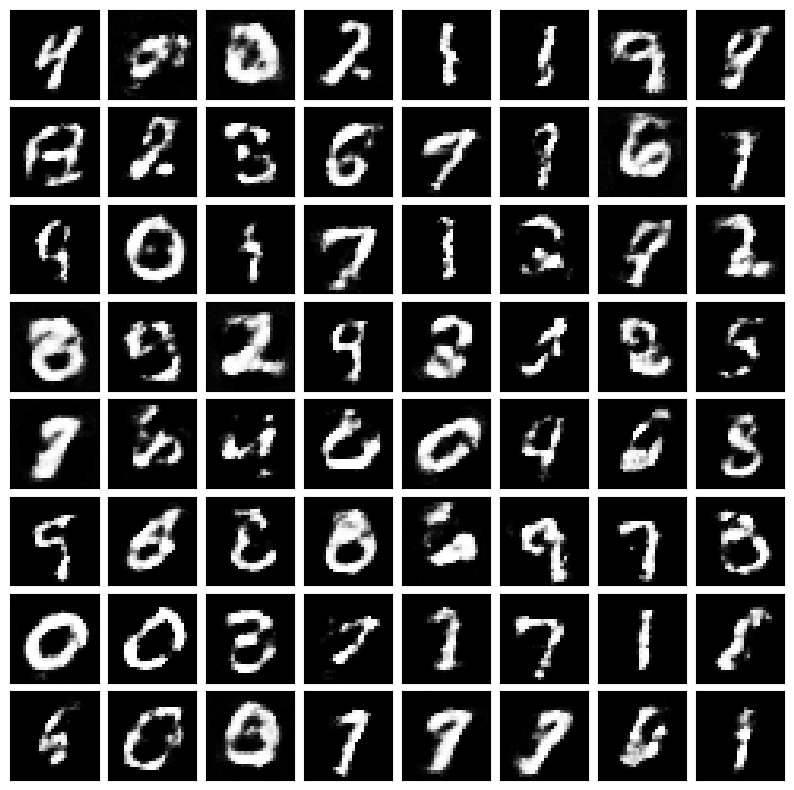

[Epoch 8/20] [Batch 0/938] [D loss: -1.245428] [G loss: -0.631187]


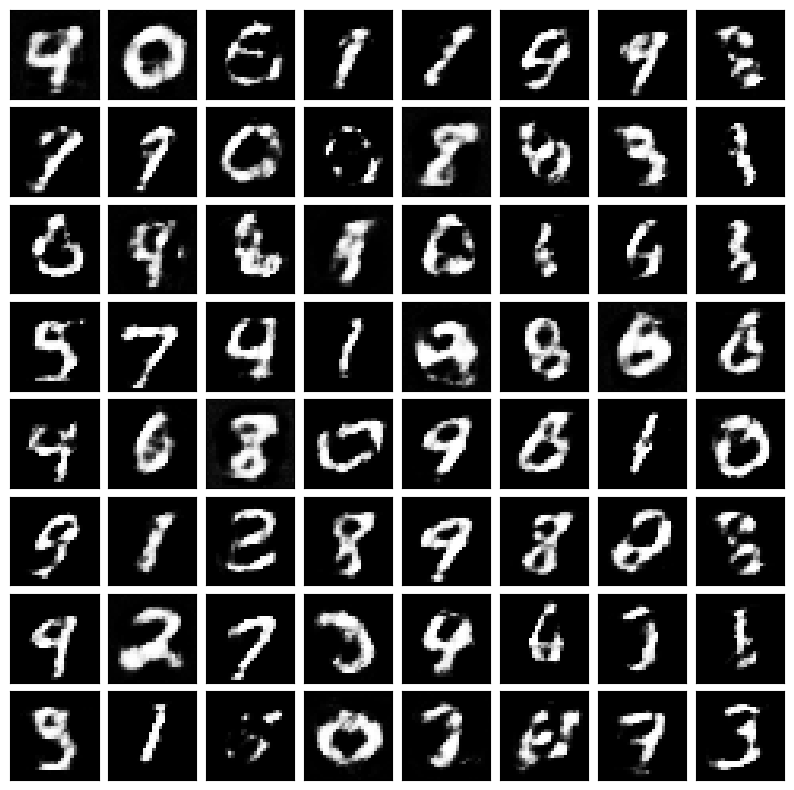

[Epoch 8/20] [Batch 600/938] [D loss: -1.577796] [G loss: -0.664629]


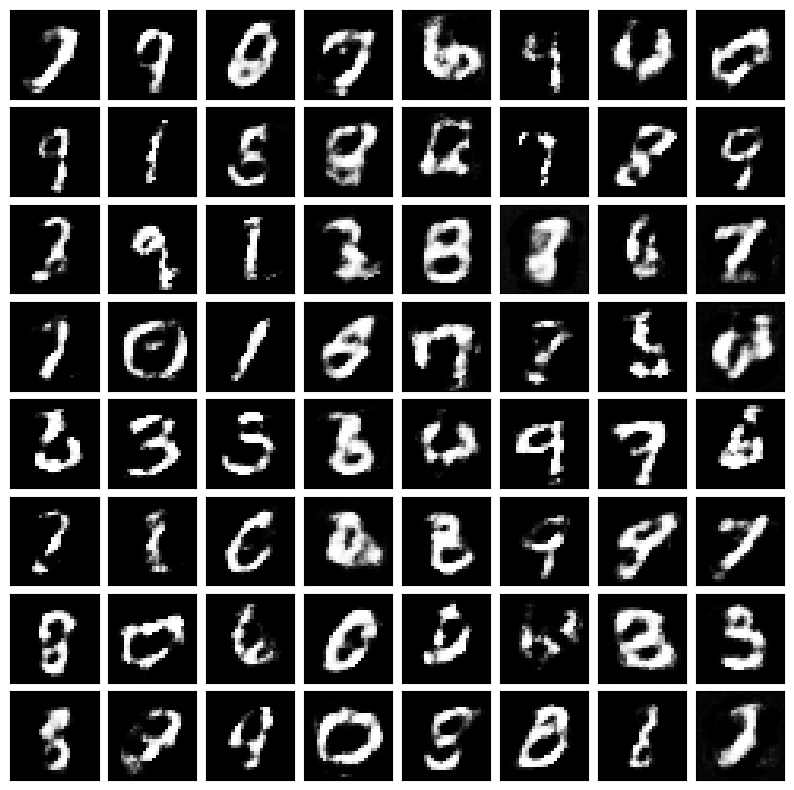

[Epoch 9/20] [Batch 0/938] [D loss: -1.244419] [G loss: -1.161699]


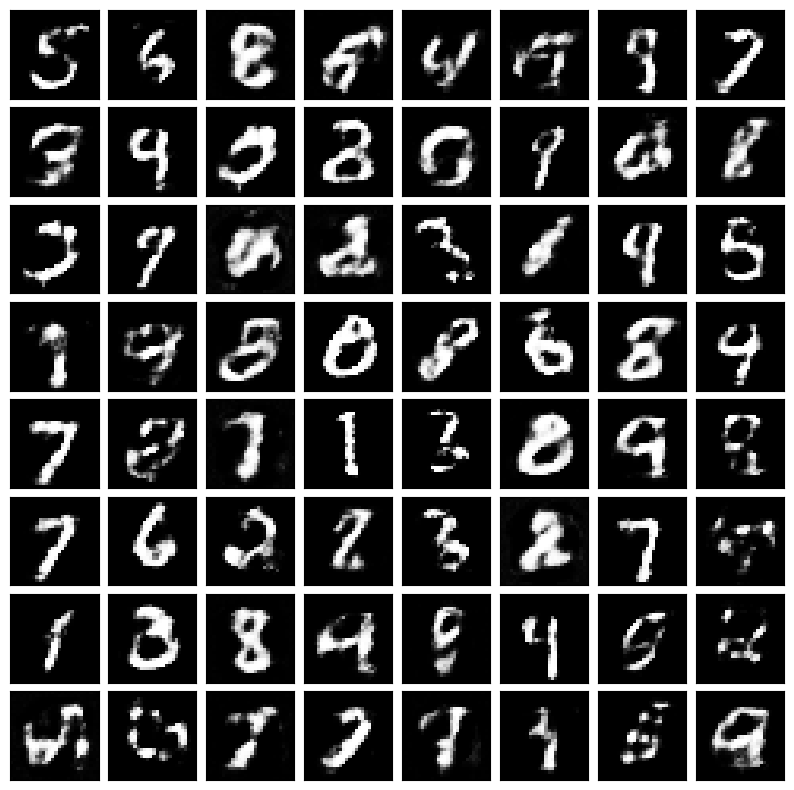

[Epoch 9/20] [Batch 600/938] [D loss: -1.276239] [G loss: -0.425604]


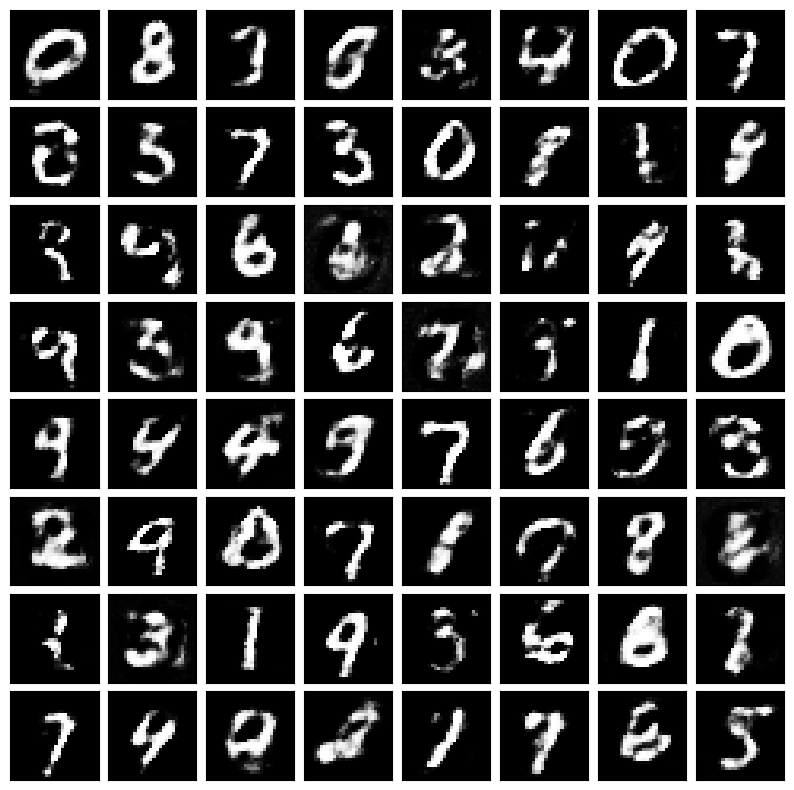

[Epoch 10/20] [Batch 0/938] [D loss: -1.026473] [G loss: 0.122699]


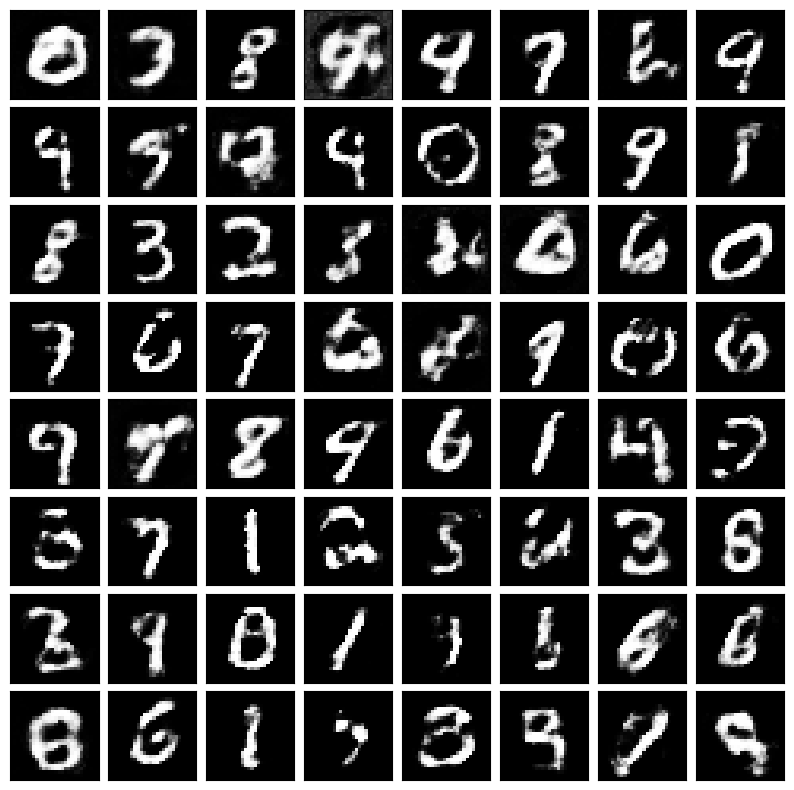

[Epoch 10/20] [Batch 600/938] [D loss: -1.145888] [G loss: -1.379607]


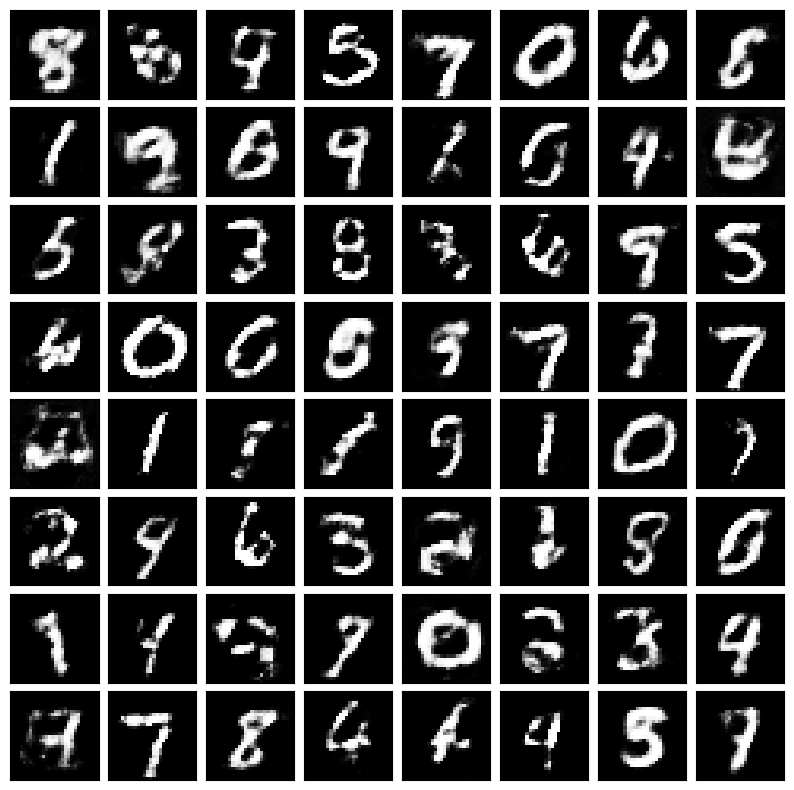

[Epoch 11/20] [Batch 0/938] [D loss: -1.127203] [G loss: -0.368401]


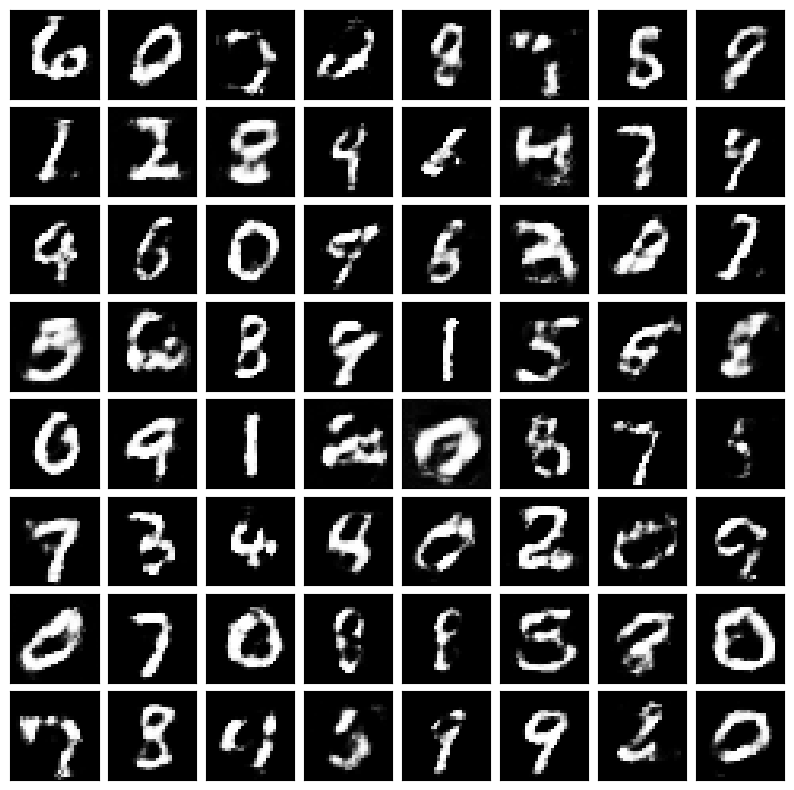

[Epoch 11/20] [Batch 600/938] [D loss: -1.269162] [G loss: -1.244158]


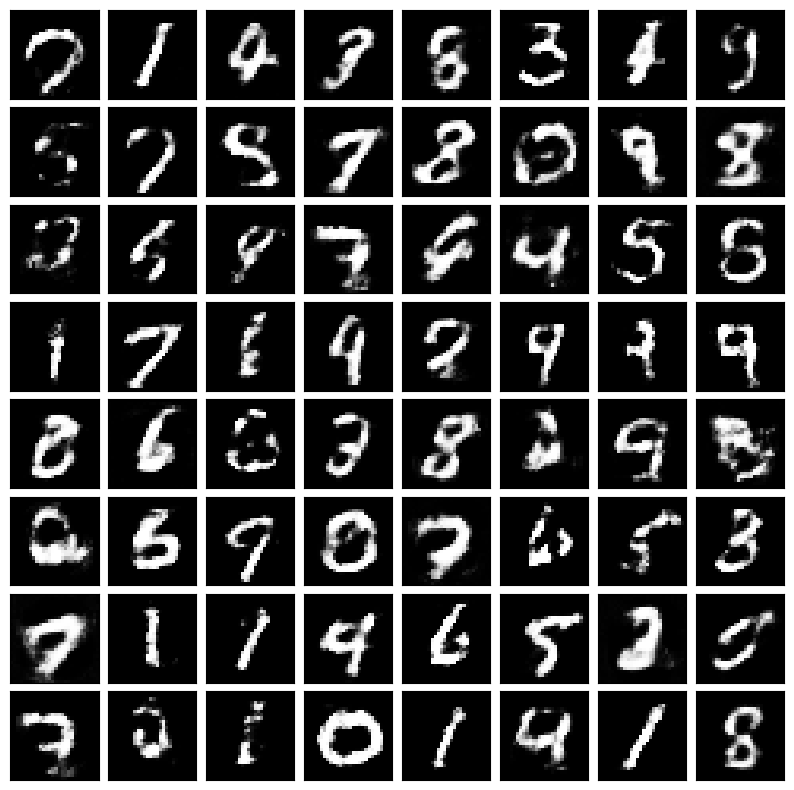

[Epoch 12/20] [Batch 0/938] [D loss: -1.043318] [G loss: -0.761623]


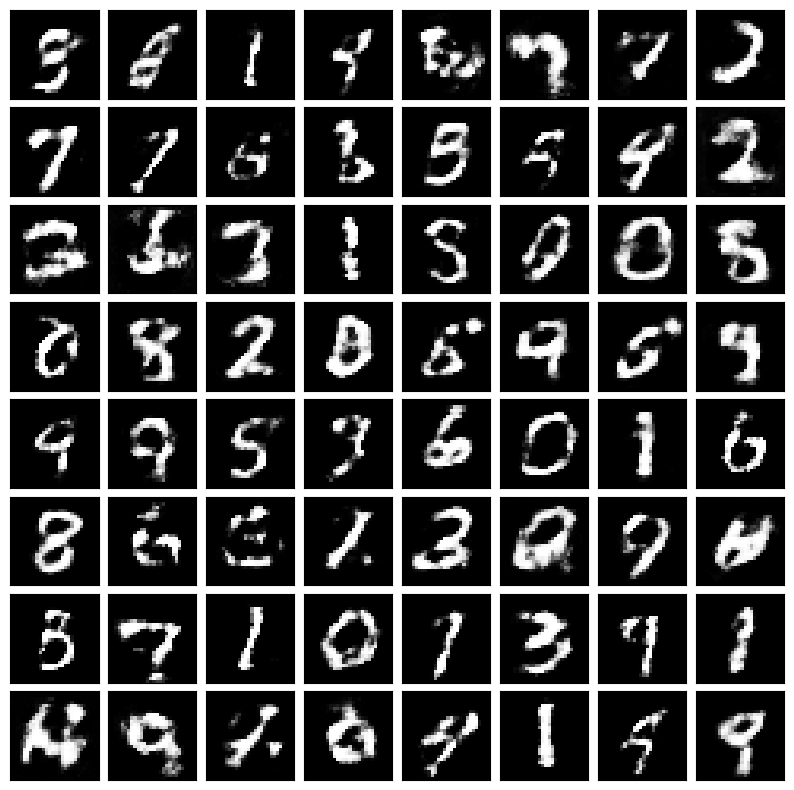

[Epoch 12/20] [Batch 600/938] [D loss: -1.100770] [G loss: -0.216495]


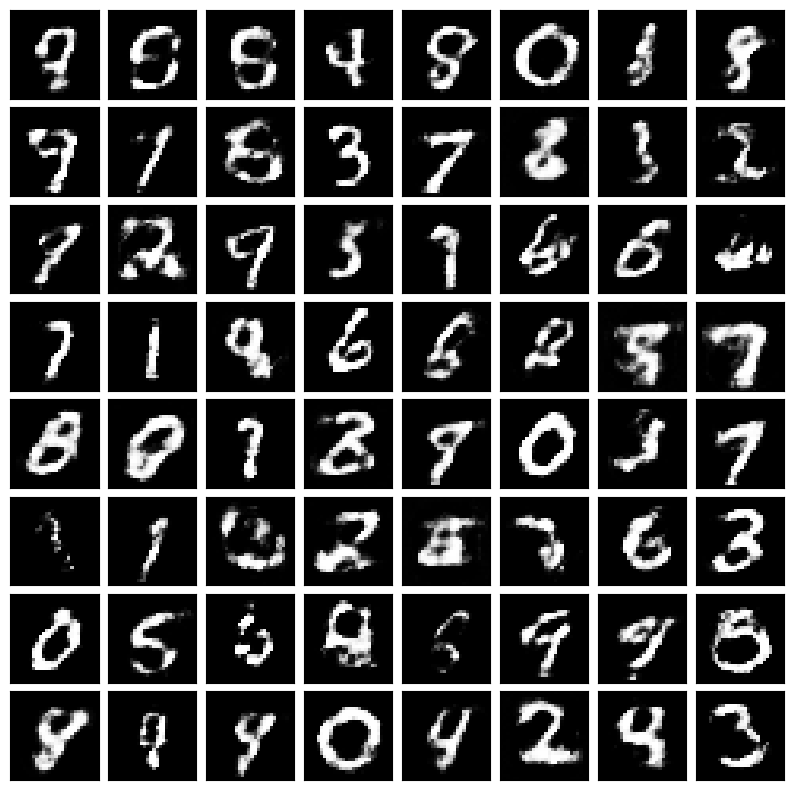

[Epoch 13/20] [Batch 0/938] [D loss: -0.906723] [G loss: -2.004886]


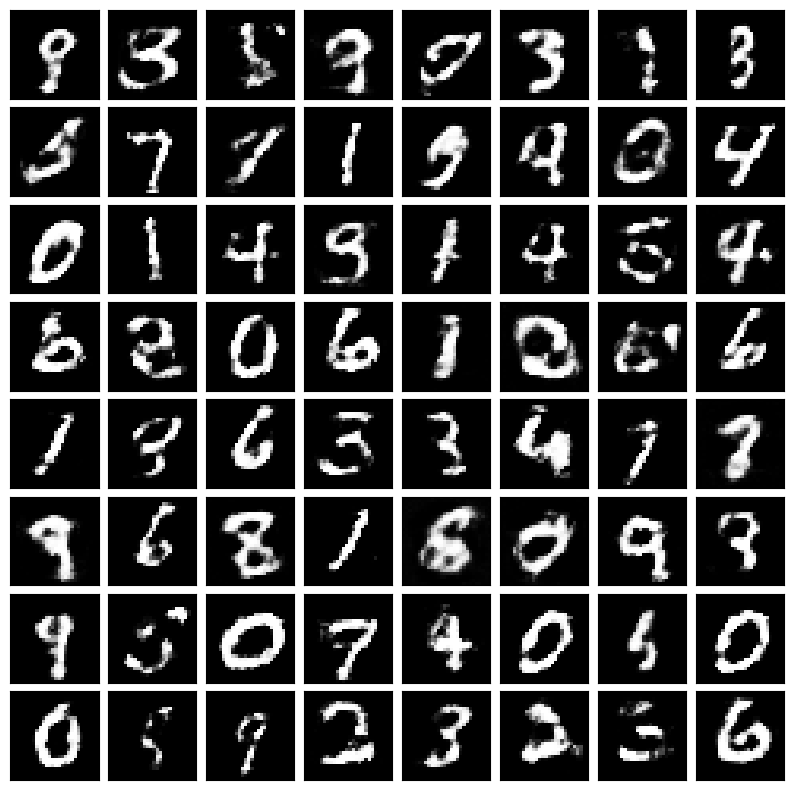

[Epoch 13/20] [Batch 600/938] [D loss: -1.156449] [G loss: -0.768813]


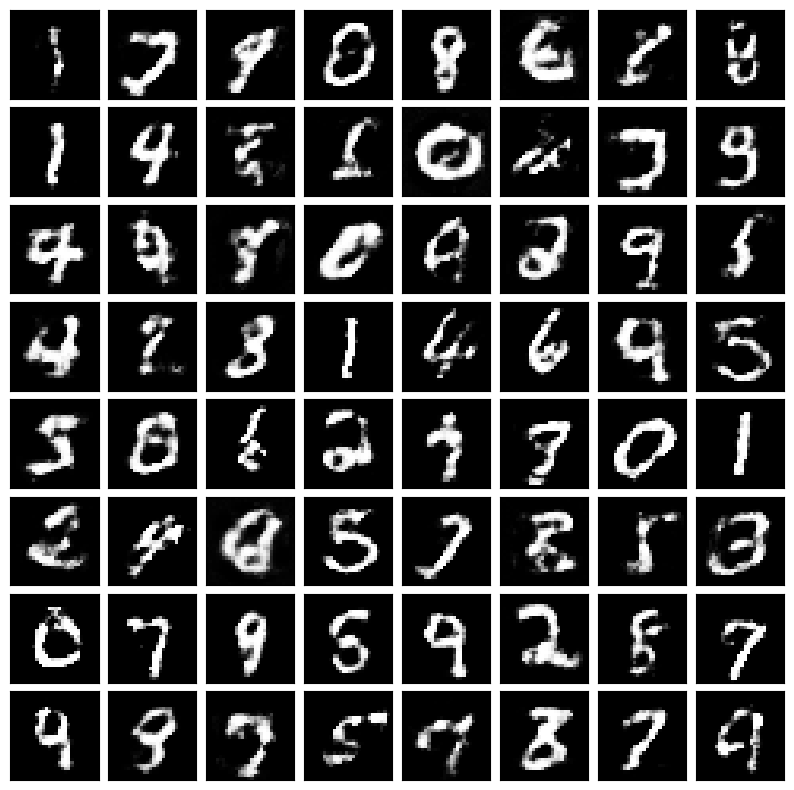

[Epoch 14/20] [Batch 0/938] [D loss: -0.690942] [G loss: -1.059387]


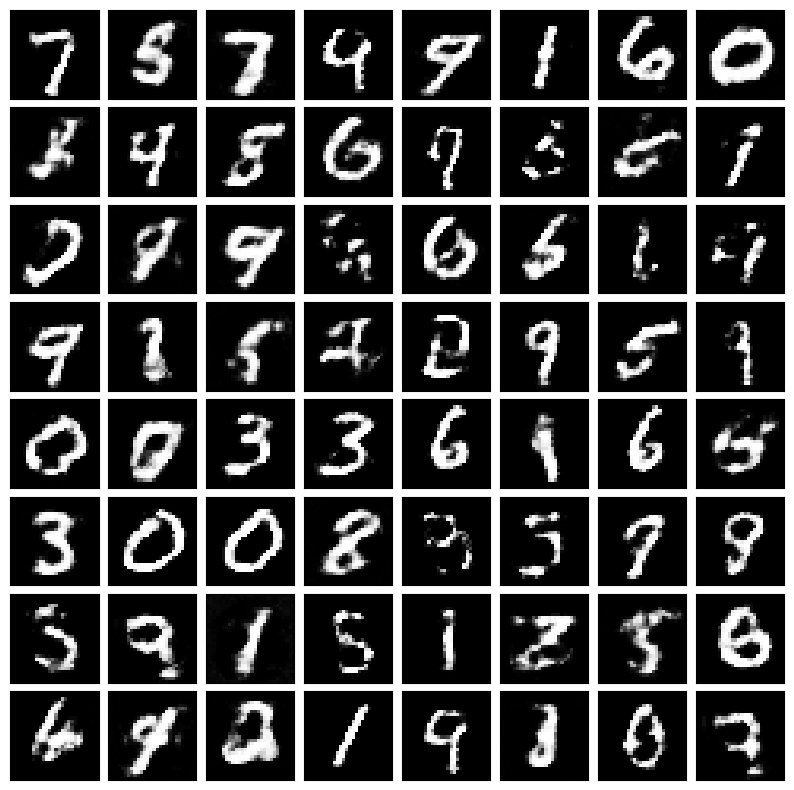

[Epoch 14/20] [Batch 600/938] [D loss: -0.831302] [G loss: -1.154708]


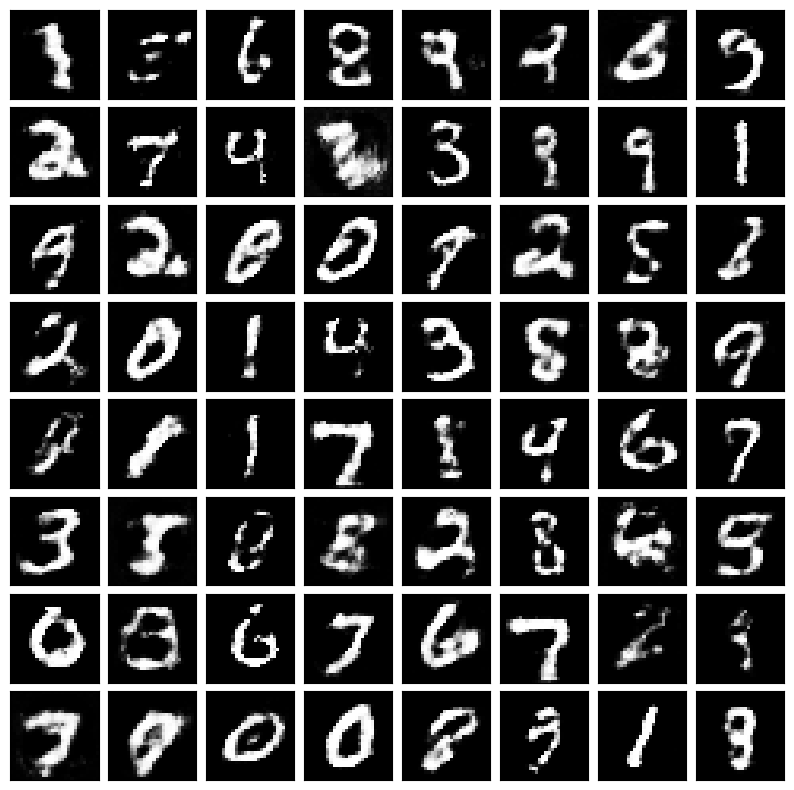

[Epoch 15/20] [Batch 0/938] [D loss: -0.775863] [G loss: -0.719486]


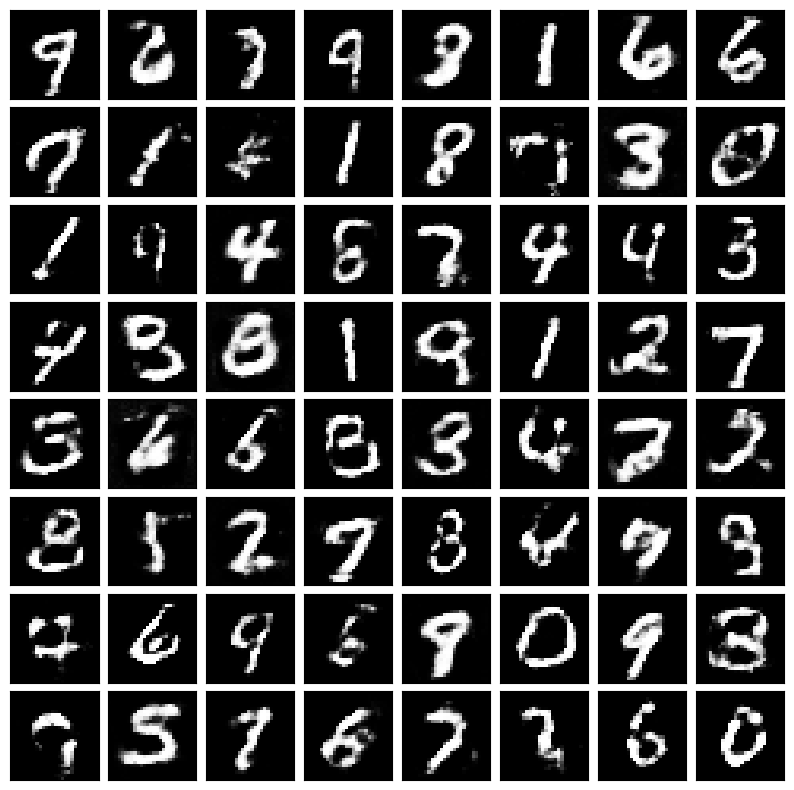

[Epoch 15/20] [Batch 600/938] [D loss: -0.936490] [G loss: 0.039654]


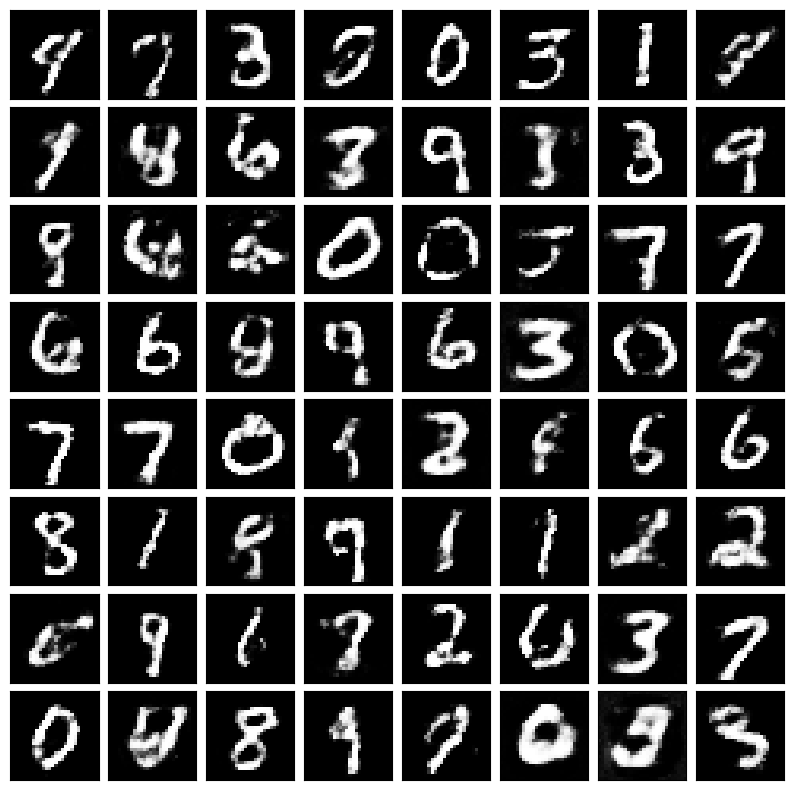

[Epoch 16/20] [Batch 0/938] [D loss: -0.461235] [G loss: -0.774557]


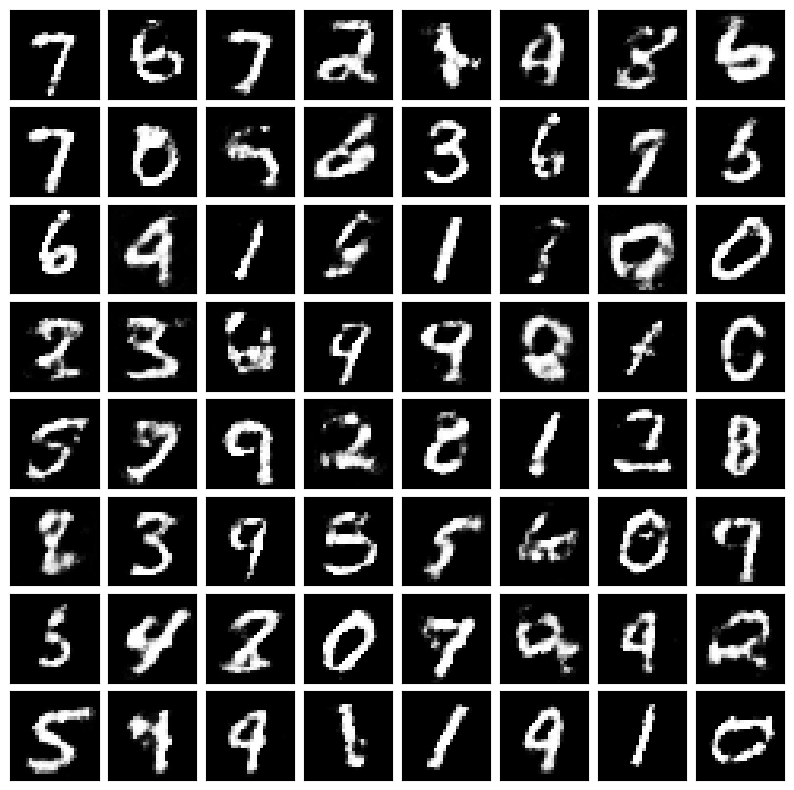

[Epoch 16/20] [Batch 600/938] [D loss: -1.285776] [G loss: -1.641161]


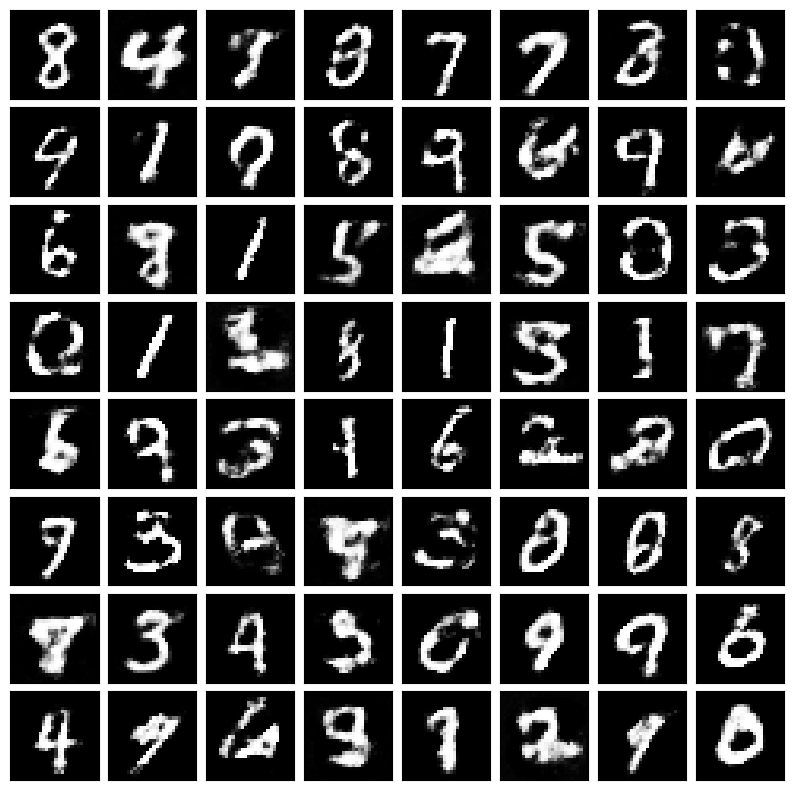

[Epoch 17/20] [Batch 0/938] [D loss: -0.877320] [G loss: -0.463272]


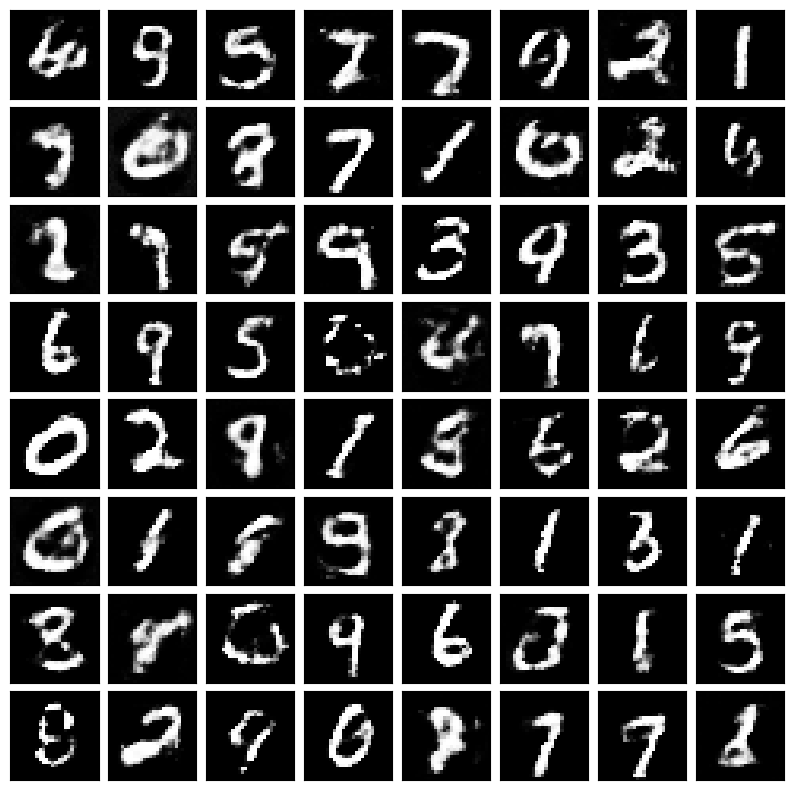

[Epoch 17/20] [Batch 600/938] [D loss: -0.908165] [G loss: -1.142585]


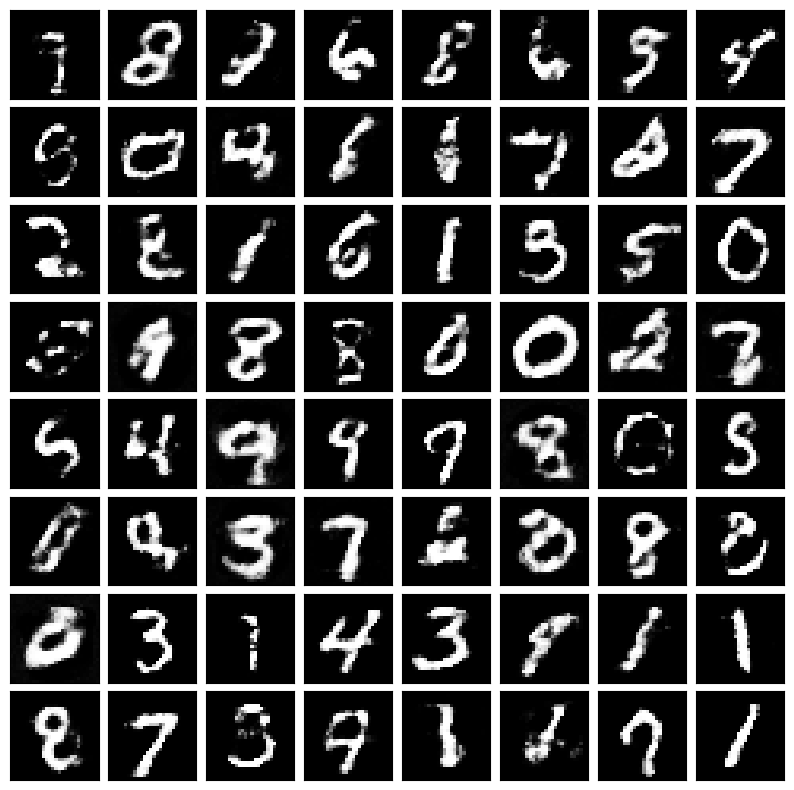

[Epoch 18/20] [Batch 0/938] [D loss: -1.300498] [G loss: -1.282565]


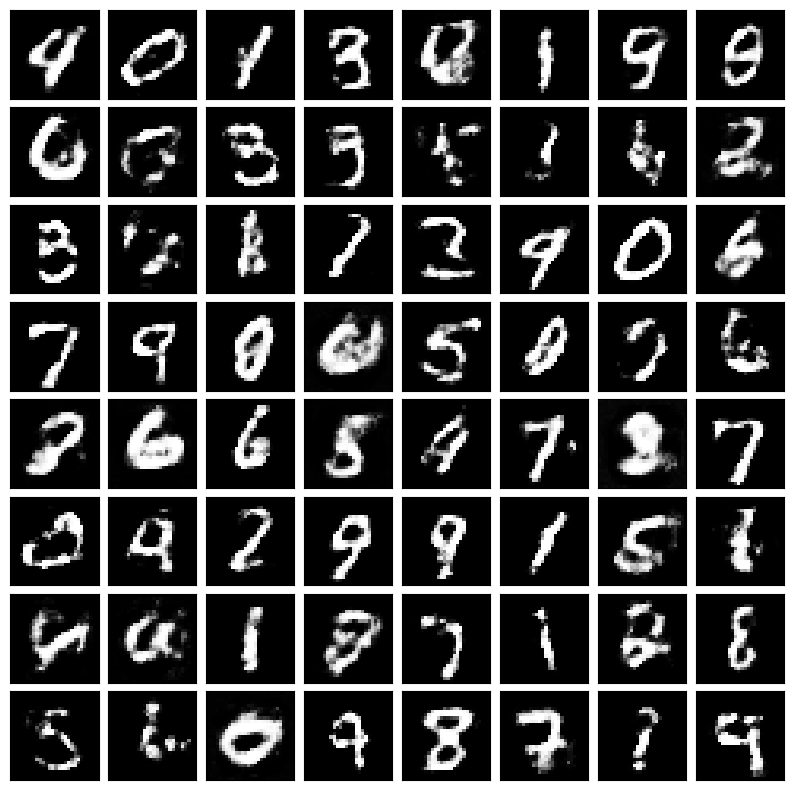

[Epoch 18/20] [Batch 600/938] [D loss: -0.909321] [G loss: -0.781748]


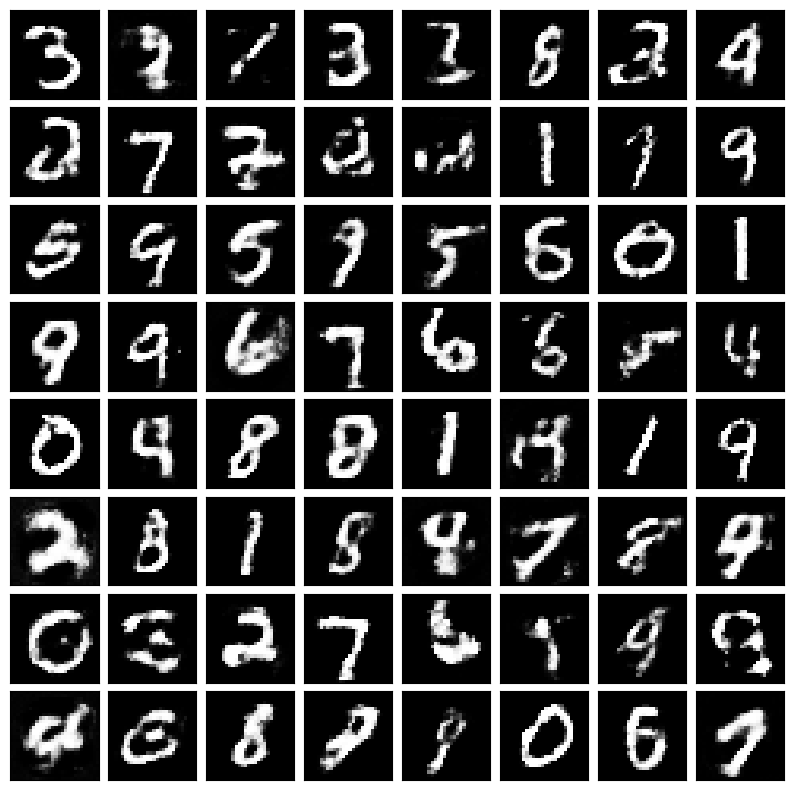

[Epoch 19/20] [Batch 0/938] [D loss: -0.787738] [G loss: -1.121050]


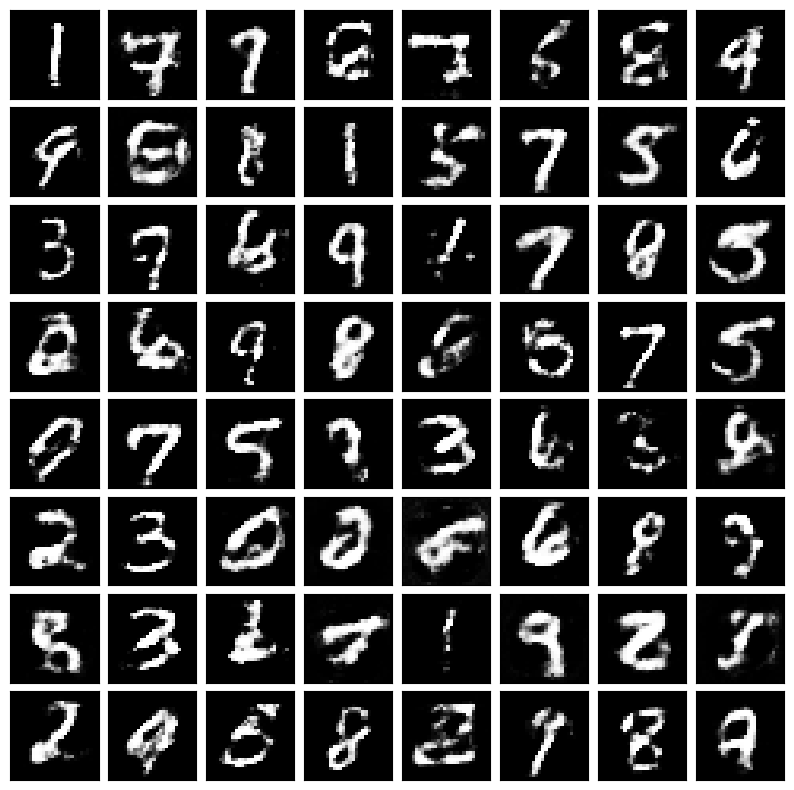

[Epoch 19/20] [Batch 600/938] [D loss: -0.402784] [G loss: -1.359086]


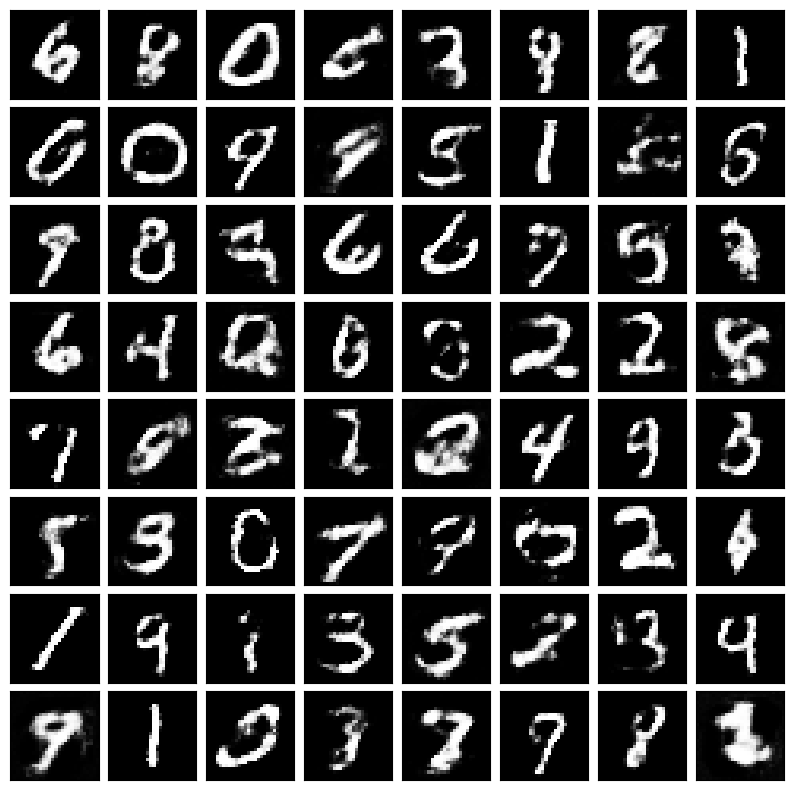

In [7]:
# ----------
#  Training
# ----------

batches_done = 0
for epoch in range(opt.n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor), requires_grad=True)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z)

        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)

        # Compute W-div gradient penalty
        real_grad_out = Variable(Tensor(real_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        real_grad = autograd.grad(
            real_validity, real_imgs, real_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        real_grad_norm = real_grad.view(real_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        fake_grad_out = Variable(Tensor(fake_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake_grad = autograd.grad(
            fake_validity, fake_imgs, fake_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        fake_grad_norm = fake_grad.view(fake_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        div_gp = torch.mean(real_grad_norm + fake_grad_norm) * k / 2

        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + div_gp

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if i % opt.n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()

            batches_done += opt.n_critic

            if i%600==0:
                print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
                )
                images = fake_imgs.data.detach().cpu()
                images = images * 0.5 + 0.5  # Revert the normalization to visualize the images properly

                # Create a figure to display the images in an 8x8 grid
                fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(10, 10))
                plt.subplots_adjust(wspace=0.1, hspace=0.1)

                # Plot each image in the 8x8 grid
                for i, ax in enumerate(axes.flat):
                    ax.imshow(images[i].squeeze(), cmap='gray')
                    ax.set_xticks([])
                    ax.set_yticks([])
                plt.show()